In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import osmnx as ox
import geopandas as gpd
from geopy.distance import geodesic
import time
from shapely.geometry import Point
from shapely.ops import unary_union
from geopy.distance import geodesic

In [2]:
df = pd.read_csv('df_combined.csv', low_memory=False)
df.head()

,Property ID,Listing Title,Property Type,Listing Type,Created Date,Last Scraped Date,Country,State,City,Currency Native,...,distancia_centros_sociales,id_centros_sociales,distancia_marketplace,id_marketplace,distancia_vida_nocturna,id_vida_nocturna,distancia_bus_station,id_bus_station,distancia_boat_rental,id_boat_rental
0,ab-604957749777772414,Stunning apartment in Torrevieja with kitchen,Rental unit,Entire home/apt,2022-06-23,2023-11-19,Spain,Alicante,Torrevieja,EUR,...,2523.240305,14971950,1585.828662,14503849,1920.373573,151875944,3377.163543,6781893685,3164.065772,10670717677
1,ab-604957750694158984,Stunning apartment in Torrevieja with 2 Bedrooms,Rental unit,Entire home/apt,2022-05-28,2023-05-25,Spain,Alicante,Torrevieja,EUR,...,107.724824,4167282094,1301.386871,9743932,2241.978322,4165921072,965.775898,318932902,977.672431,10670717677
2,ab-604966316637801053,Precioso alojamiento con terraza,Vacation home,Entire home/apt,2022-04-18,2023-11-19,Spain,Alicante,Torrevieja,EUR,...,1495.908764,14971950,809.832507,14503849,1044.212046,151875944,2426.303263,6781893685,2541.301776,10670717677
3,ab-605014266200913335,Precioso apartamento en complejo residencial,Condo,Entire home/apt,2022-04-22,2023-11-18,Spain,Alicante,Torrevieja,EUR,...,3665.583198,4167282094,4358.572665,3572435942,4432.922961,3574175218,4175.208236,318932902,3902.987920,10000743459
4,ab-605108518012999409,ALQUILER VACACIONAL TORREVIEJA!!,Rental unit,Entire home/apt,2022-04-18,2022-06-24,Spain,Alicante,Torrevieja,EUR,...,593.350814,6696825285,813.162785,10923649779,683.518953,4165921072,597.444631,6781893685,1139.539572,10670717677


## Matriz de correlaciones

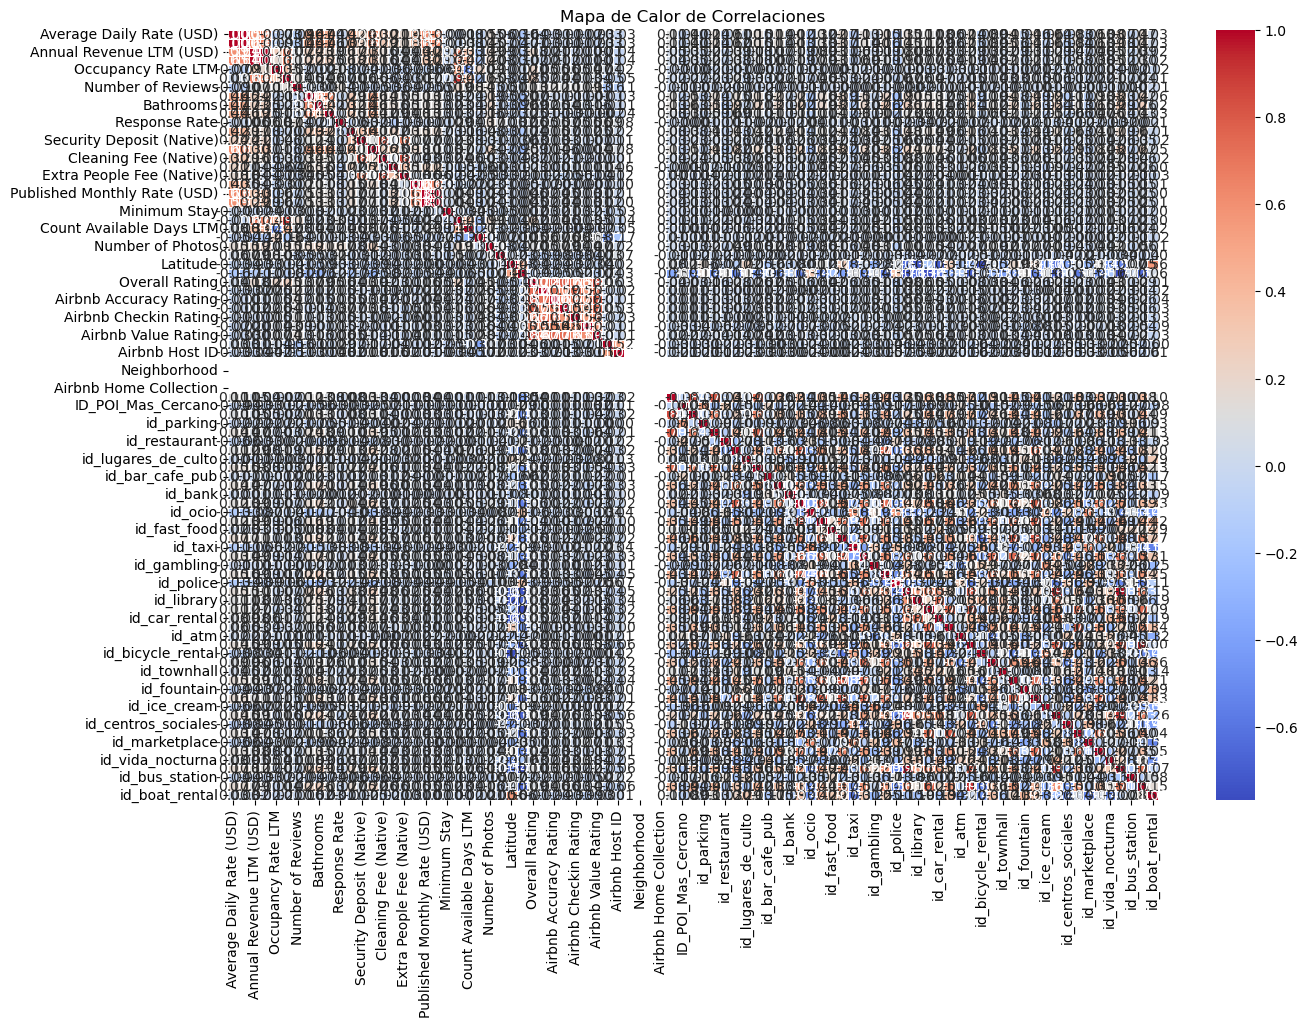

In [4]:
from sklearn.preprocessing import LabelEncoder

# Convertir variables categóricas (de tipo 'object') en variables numéricas usando LabelEncoder
# Si tienes muchas variables categóricas, esto las convertirá a valores numéricos
#for col in df.select_dtypes(include=['object']).columns:
#    le = LabelEncoder()
#    df[col] = le.fit_transform(df[col].astype(str))

# Eliminar las columnas de tipo 'object' (string)
df_numerical = df.select_dtypes(exclude=['object'])

# Calcular la matriz de correlación
corr_matrix = df_numerical.corr()

# Usamos seaborn para visualizar la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones')
plt.show()

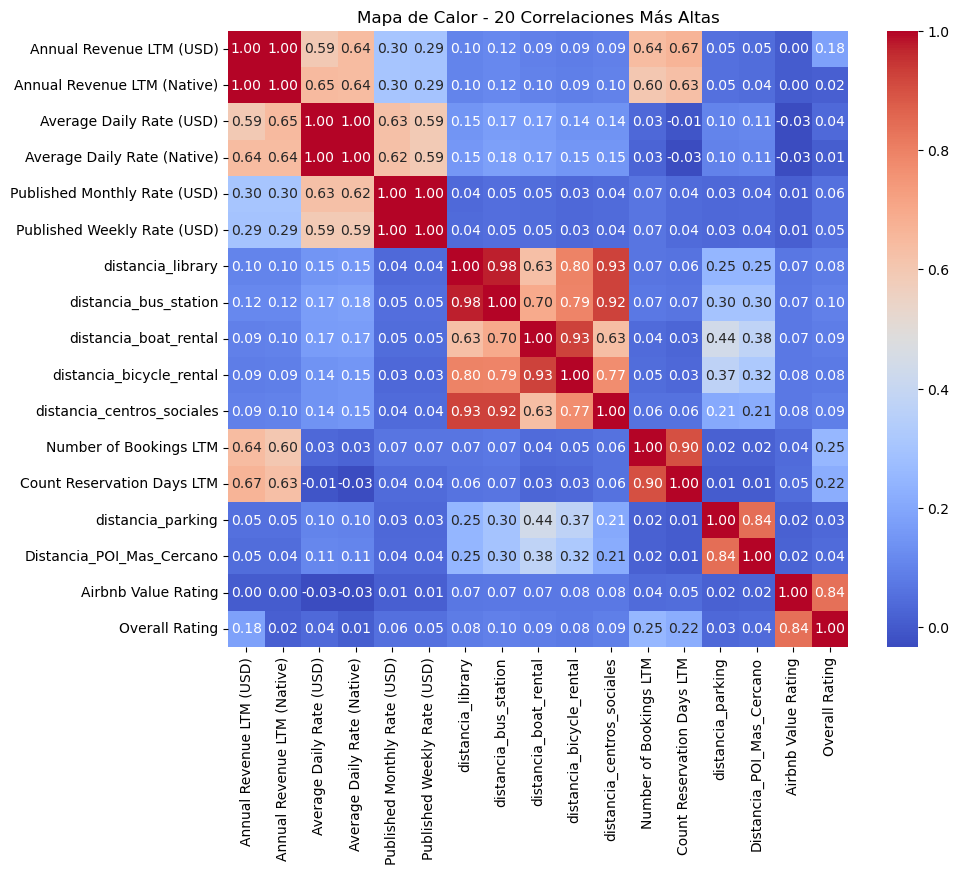

In [5]:
# Ordenar las correlaciones en orden descendente y seleccionar las 20 más altas
corr_matrix = df_numerical.corr().abs()
corr_values = corr_matrix.unstack().sort_values(ascending=False)

# Filtrar las 20 correlaciones más altas, omitiendo la diagonal
top_20_corr = corr_values[(corr_values < 1)].head(20)

# Mostrar el mapa de calor solo de las correlaciones más altas
top_20_corr_matrix = df_numerical[top_20_corr.index.get_level_values(0).unique()]
corr_matrix_top_20 = top_20_corr_matrix.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_top_20, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor - 20 Correlaciones Más Altas')
plt.show()


## POIs dentro de un rango de 2KM

In [33]:
# Filtrar columnas de distancia
dist_columns = [col for col in df.columns if col.startswith('distancia_')]

# Para cada fila, comprobar si las columnasd de distancia cumplen la condición
df['num_pois_mayor_2km'] = (df[dist_columns] < 2000).sum(axis=1)

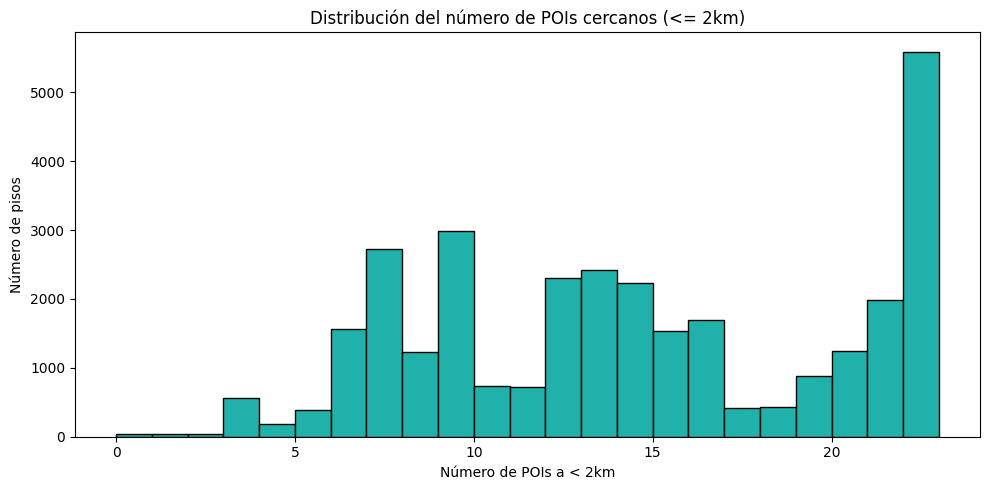

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(df['num_pois_mayor_2km'], bins=range(df['num_pois_mayor_2km'].max() + 2), color='lightseagreen', edgecolor='black')
plt.xlabel('Número de POIs a < 2km')
plt.ylabel('Número de pisos')
plt.title('Distribución del número de POIs cercanos (<= 2km)')
plt.tight_layout()
plt.show()


In [35]:
import folium

# Crear mapa centrado (puedes usar el promedio de coordenadas como centro)
center = [df['Latitude'].mean(), df['Longitude'].mean()]
m = folium.Map(location=center, zoom_start=13)

# Función para determinar el color 
def get_color(num_pois):
    if num_pois <= 5:
        return 'red'
    elif num_pois <= 10:
        return 'orange'
    else:
        return 'green'
    
# Añadir cada piso al mapa con color según la cantidad de POIs cercanos
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=f"Piso {row['Property ID']}<br>{row['num_pois_mayor_2km']} POIs < 2km",
        color=get_color(row['num_pois_mayor_2km']),
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Guardar el mapa como HTML o mostrarlo directamente si estás en Jupyter
m.save("mapa_pisos_pois.html")
